In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
dfs = []

for year in range(2011, 2026):
    try:
        df = pd.read_csv(f"NVDA_{year}.csv")
        df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
        dfs.append(df)
    except FileNotFoundError:
        print(f"Missing file: NVDA_{year}.csv")

nvda_stock = pd.concat(dfs, ignore_index=True)
nvda_stock = nvda_stock.sort_values("Date")
nvda_stock = nvda_stock.rename(columns={'Date':'date'})

In [3]:
nvda_stock.to_csv("nvda_stock.csv", index=False)

In [4]:
nvda_stock.head()

,date,Open,High,Low,Close,Volume
251,2011-01-03,0.39,0.40,0.39,0.40,"817,512,792"
250,2011-01-04,0.40,0.40,0.39,0.39,"651,424,393"
249,2011-01-05,0.40,0.43,0.40,0.42,"1,428,212,786"
248,2011-01-06,0.44,0.48,0.43,0.48,"3,493,309,045"
247,2011-01-07,0.48,0.50,0.47,0.50,"2,580,377,494"


In [5]:
# Load dataset
analyst_df = pd.read_csv("connected_data_all.csv")

# Filter NVDA rows
nvda_analyst = analyst_df[
    analyst_df["ticker"].str.upper().str.strip() == "NVDA"
].copy()

# Convert date
nvda_analyst["date"] = pd.to_datetime(nvda_analyst["date"])

# Clean price targets row-wise
def clean_price_targets(row):
    before = row["price_target_before"]
    after = row["price_target_after"]

    if isinstance(before, str):
        for sep in ["»", "–", "-", "→"]:
            if sep in before:
                parts = before.split(sep)
                try:
                    return pd.Series([
                        float(parts[0].strip()),
                        float(parts[1].strip())
                    ])
                except:
                    return pd.Series([None, None])

    try:
        before_val = float(before)
    except:
        before_val = None

    try:
        after_val = float(after)
    except:
        after_val = None

    return pd.Series([before_val, after_val])

nvda_analyst[["price_target_before", "price_target_after"]] = (
    nvda_analyst.apply(clean_price_targets, axis=1)
)

nvda_analyst["price_target_before"] = pd.to_numeric(
    nvda_analyst["price_target_before"], errors="coerce"
)

nvda_analyst["price_target_after"] = pd.to_numeric(
    nvda_analyst["price_target_after"], errors="coerce"
)

nvda_analyst = nvda_analyst.sort_values("date").reset_index(drop=True)
nvda_analyst = nvda_analyst.loc[:, ~nvda_analyst.columns.str.contains("^Unnamed")]
nvda_analyst = nvda_analyst.rename(columns={'analytst':'analyst'})
nvda_analyst.to_csv("nvda_analyst.csv", index=False)

In [6]:
nvda_analyst.head()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after
0,2013-11-18,Nvidia Corp,NVDA,MORGAN STANLEY,JOSEPH MOORE,NaN,UNDERWEIGHT,NaN,0.32
1,2014-02-13,Nvidia Corp,NVDA,SUSQUEHANNA,CHRIS CASO,,NEUTRAL,0.35,0.37
2,2014-02-13,Nvidia Corp,NVDA,MORGAN STANLEY,JOSEPH MOORE,NaN,UNDERWEIGHT,NaN,0.32
3,2014-03-19,Nvidia Corp,NVDA,STIFEL,KEVIN CASSIDY,BUY,BUY,0.47,0.52
4,2014-03-24,Nvidia Corp,NVDA,B. RILEY,CHRISTOPHER ROLLAND,NaN,MARKET PERFORM,NaN,0.42


In [7]:
nvda_stock = pd.read_csv("nvda_stock.csv")
nvda_stock_needed = nvda_stock[['date', 'Close']]
nvda_stock_needed.to_csv("nvda_stock_needed.csv", index=False)

In [8]:
nvda_stock_needed.head()

,date,Close
0,2011-01-03,0.40
1,2011-01-04,0.39
2,2011-01-05,0.42
3,2011-01-06,0.48
4,2011-01-07,0.50


In [9]:
clean_analyst = pd.read_csv("nvda_analyst.csv")
clean_stock = pd.read_csv("nvda_stock_needed.csv")

nvda_clean = clean_analyst.merge(
    clean_stock,
    on="date",
    how="left"
)

nvda_clean = nvda_clean.sort_values("date").reset_index(drop=True)
nvda_clean.to_csv("nvda_clean.csv", index=False)

In [10]:
nvda_clean.head()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after,Close
0,2013-11-18,Nvidia Corp,NVDA,MORGAN STANLEY,JOSEPH MOORE,NaN,UNDERWEIGHT,NaN,0.32,0.39
1,2014-02-13,Nvidia Corp,NVDA,SUSQUEHANNA,CHRIS CASO,,NEUTRAL,0.35,0.37,0.43
2,2014-02-13,Nvidia Corp,NVDA,MORGAN STANLEY,JOSEPH MOORE,NaN,UNDERWEIGHT,NaN,0.32,0.43
3,2014-03-19,Nvidia Corp,NVDA,STIFEL,KEVIN CASSIDY,BUY,BUY,0.47,0.52,0.46
4,2014-03-24,Nvidia Corp,NVDA,B. RILEY,CHRISTOPHER ROLLAND,NaN,MARKET PERFORM,NaN,0.42,0.46


In [11]:
print(nvda_clean.dtypes)

date                    object
company_Name            object
ticker                  object
broker                  object
analyst                 object
rating_before           object
rating_after            object
price_target_before    float64
price_target_after     float64
Close                  float64
dtype: object


In [12]:
def days_to_hit_target(analyst_data, stock_data):
    analyst_data = analyst_data.copy()
    stock_data = stock_data.copy()

    analyst_data["date"] = pd.to_datetime(analyst_data["date"], errors="coerce")
    stock_data["date"] = pd.to_datetime(stock_data["date"], errors="coerce")

    analyst_data = analyst_data.dropna(subset=["date"])
    stock_data = stock_data.dropna(subset=["date"])

    stock_data = stock_data.sort_values("date")

    def compute_days(row):
        start_date = row["date"]
        target = row["price_target_after"]

        if pd.isna(target):
            return np.nan

        future_stocks = stock_data[stock_data["date"] > start_date]

        if future_stocks.empty:
            return np.nan

        if target >= row["Close"]:
            hit = future_stocks[future_stocks["High"] >= target]
        else:
            hit = future_stocks[future_stocks["Low"] <= target]

        if hit.empty:
            return np.nan

        hit_date = hit.iloc[0]["date"]

        return (future_stocks["date"] <= hit_date).sum()

    analyst_data["days_to_target"] = analyst_data.apply(compute_days, axis=1)

    return analyst_data

In [13]:
nvda_stock.head()

,date,Open,High,Low,Close,Volume
0,2011-01-03,0.39,0.40,0.39,0.40,"817,512,792"
1,2011-01-04,0.40,0.40,0.39,0.39,"651,424,393"
2,2011-01-05,0.40,0.43,0.40,0.42,"1,428,212,786"
3,2011-01-06,0.44,0.48,0.43,0.48,"3,493,309,045"
4,2011-01-07,0.48,0.50,0.47,0.50,"2,580,377,494"


In [14]:
days_to_hit_target(nvda_clean, nvda_stock).head()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after,Close,days_to_target
0,2013-11-18,Nvidia Corp,NVDA,MORGAN STANLEY,JOSEPH MOORE,NaN,UNDERWEIGHT,NaN,0.32,0.39,NaN
1,2014-02-13,Nvidia Corp,NVDA,SUSQUEHANNA,CHRIS CASO,,NEUTRAL,0.35,0.37,0.43,NaN
2,2014-02-13,Nvidia Corp,NVDA,MORGAN STANLEY,JOSEPH MOORE,NaN,UNDERWEIGHT,NaN,0.32,0.43,NaN
3,2014-03-19,Nvidia Corp,NVDA,STIFEL,KEVIN CASSIDY,BUY,BUY,0.47,0.52,0.46,163.0
4,2014-03-24,Nvidia Corp,NVDA,B. RILEY,CHRISTOPHER ROLLAND,NaN,MARKET PERFORM,NaN,0.42,0.46,140.0


In [15]:
nvda_final = days_to_hit_target(nvda_clean, nvda_stock)

In [16]:
nvda_final['pt_close_difference'] = abs(nvda_final['price_target_after'] - nvda_final['Close'])
nvda_final.tail()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after,Close,days_to_target,pt_close_difference
1001,2025-08-18,Nvidia Corp,NVDA,NaN,C J MUSE,Overweight,Overweight,240.0,240.0,182.01,NaN,57.99
1002,2025-08-20,Nvidia Corp,NVDA,NaN,JOHN VINH,Overweight,Overweight,215.0,215.0,175.40,NaN,39.60
1003,2025-08-22,Nvidia Corp,NVDA,NaN,MARK LIPACIS,Outperform,Outperform,214.0,214.0,177.99,NaN,36.01
1004,2025-09-08,Nvidia Corp,NVDA,NaN,ATIF MALIK,Buy,Buy,200.0,200.0,168.31,36.0,31.69
1005,2025-09-11,Nvidia Corp,NVDA,NaN,GIL LURIA,Neutral,Buy,210.0,210.0,177.17,34.0,32.83


In [17]:
nvda_final_no_nan = nvda_final.dropna(subset=['days_to_target'])
nvda_final_no_nan.head()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after,Close,days_to_target,pt_close_difference
3,2014-03-19,Nvidia Corp,NVDA,STIFEL,KEVIN CASSIDY,BUY,BUY,0.47,0.52,0.46,163.0,0.06
4,2014-03-24,Nvidia Corp,NVDA,B. RILEY,CHRISTOPHER ROLLAND,NaN,MARKET PERFORM,NaN,0.42,0.46,140.0,0.04
6,2014-05-09,Nvidia Corp,NVDA,STIFEL,KEVIN CASSIDY,Buy,Buy,22.00,22.00,0.45,1835.0,21.55
7,2014-06-19,Nvidia Corp,NVDA,BAML,VIVEK ARYA,NEUTRAL,UNDERPERFORM,NaN,0.47,0.48,1.0,0.01
9,2014-08-08,Nvidia Corp,NVDA,B. RILEY,CHRISTOPHER ROLLAND,MARKET PERFORM,MARKET PERFO,NaN,0.50,0.48,18.0,0.02


In [18]:
nvda_final.to_csv("nvda_final.csv", index=False)
nvda_final_no_nan.to_csv("nvda_final_no_nan.csv", index=False)

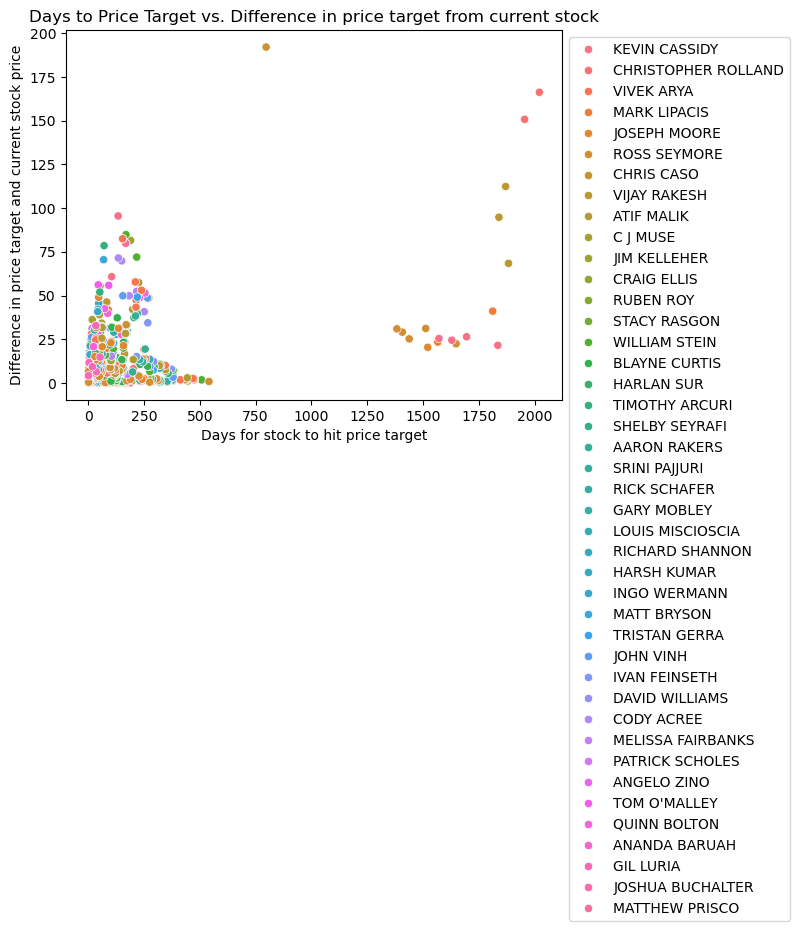

In [19]:
sns.scatterplot(nvda_final_no_nan, x='days_to_target', y='pt_close_difference', hue='analyst')
plt.title('Days to Price Target vs. Difference in price target from current stock')
plt.xlabel('Days for stock to hit price target')
plt.ylabel('Difference in price target and current stock price')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [20]:
analyst_performance = (
    nvda_final
    .groupby("analyst")
    .agg(
        total_predictions=("analyst", "count"),
        targets_hit=("days_to_target", lambda x: x.notna().sum()),
        hit_rate=("days_to_target", lambda x: x.notna().mean()),
        avg_pt_close_difference=("pt_close_difference", "mean"),
        avg_days_to_target=("days_to_target", "mean")
    )
    .reset_index()
)

In [21]:
analyst_performance.head()

,analyst,total_predictions,targets_hit,hit_rate,avg_pt_close_difference,avg_days_to_target
0,AARON RAKERS,34,31,0.911765,25.063636,84.806452
1,ANANDA BARUAH,3,2,0.666667,65.230000,241.500000
2,ANGELO ZINO,8,8,1.000000,8.566250,25.375000
3,ATIF MALIK,52,51,0.980769,7.973333,100.784314
4,BLAYNE CURTIS,35,33,0.942857,6.739118,97.090909


In [22]:
tech_predictions = pd.read_csv("tech-predictions.csv")

In [23]:
tech_predictions = tech_predictions.rename(columns={"analytst": "analyst"})

In [24]:
tech_predictions.head()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after
0,8/9/2012,Apple Inc,AAPL,STIFEL,AARON RAKERS,NaN,BUY,NaN,29.46
1,9/6/2013,Apple Inc,AAPL,STIFEL,AARON RAKERS,BUY,BUY,NaN,19.29
2,12/11/2015,Apple Inc,AAPL,STIFEL,AARON RAKERS,BUY,BUY,NaN,37.5
3,1/22/2016,Apple Inc,AAPL,STIFEL,AARON RAKERS,BUY,BUY,NaN,35
4,3/21/2016,Apple Inc,AAPL,STIFEL,AARON RAKERS,BUY,BUY,NaN,30


In [25]:
total_stock_predictions = (
    tech_predictions
    .groupby("analyst")
    .size()
    .reset_index(name="total_stock_predictions")
)

In [26]:
total_stock_predictions.head()

,analyst,total_stock_predictions
0,AARON KESSLER,60
1,AARON RAKERS,225
2,ABHEY LAMBA,5
3,ACHAL SULTANIA,3
4,ADAM BORG,92


In [27]:
analyst_performance = analyst_performance.merge(
    total_stock_predictions,
    on="analyst",
    how="left"
)

In [28]:
analyst_performance["hit_rate_tier"] = pd.cut(
    analyst_performance["hit_rate"],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=[
        "Very Low (0–20%)",
        "Low (20–40%)",
        "Medium (40–60%)",
        "High (60–80%)",
        "Very High (80–100%)"
    ],
    include_lowest=True
)

In [29]:
analyst_performance.head()

,analyst,total_predictions,targets_hit,hit_rate,avg_pt_close_difference,avg_days_to_target,total_stock_predictions,hit_rate_tier
0,AARON RAKERS,34,31,0.911765,25.063636,84.806452,225,Very High (80–100%)
1,ANANDA BARUAH,3,2,0.666667,65.230000,241.500000,55,High (60–80%)
2,ANGELO ZINO,8,8,1.000000,8.566250,25.375000,35,Very High (80–100%)
3,ATIF MALIK,52,51,0.980769,7.973333,100.784314,161,Very High (80–100%)
4,BLAYNE CURTIS,35,33,0.942857,6.739118,97.090909,289,Very High (80–100%)


In [30]:
analyst_performance.to_csv("nvda_analyst_data.csv", index=False)

In [31]:
hit_rate_tiers = [
    "Very Low (0–20%)",
    "Low (20–40%)",
    "Medium (40–60%)",
    "High (60–80%)",
    "Very High (80–100%)"
]

# Create the DataFrame
icon_df = pd.DataFrame({
    "hit_rate_tier": hit_rate_tiers,
    "icon": [""] * len(hit_rate_tiers),
    "width": [""] * len(hit_rate_tiers),
    "height": [""] * len(hit_rate_tiers)
})

In [32]:
icon_df.to_csv("pictogram_icon.csv", index=False)

In [33]:
outlier_analysts = ["gary mobley", "kevin cassidy", "david williams", "matthew prisco", "ananda baruah", "ross seymore"]

analyst_performance_filtered = analyst_performance[
    ~analyst_performance["analyst"]
        .str.strip()
        .str.lower()
        .isin(outlier_analysts)
].copy()

In [34]:
analyst_performance_filtered.to_csv("nvda_analyst_data_filtered.csv", index=False)

In [35]:
analyst_performance["analyst"].value_counts().head()

analyst
AARON RAKERS     1
ANANDA BARUAH    1
ANGELO ZINO      1
ATIF MALIK       1
BLAYNE CURTIS    1
Name: count, dtype: int64

In [36]:
"Gary Mobley" in analyst_performance_filtered["analyst"].values

False

In [37]:
"Kevin Cassidy" in analyst_performance_filtered["analyst"].values


False

In [38]:
print(sorted(analyst_performance["analyst"].unique()))

['AARON RAKERS', 'ANANDA BARUAH', 'ANGELO ZINO', 'ATIF MALIK', 'BLAYNE CURTIS', 'C J MUSE', 'CHRIS CASO', 'CHRISTOPHER ROLLAND', 'CODY ACREE', 'CRAIG ELLIS', 'DAVID WILLIAMS', 'GARY MOBLEY', 'GIL LURIA', 'HARLAN SUR', 'HARSH KUMAR', 'INGO WERMANN', 'IVAN FEINSETH', 'JIM KELLEHER', 'JOHN VINH', 'JOSEPH MOORE', 'JOSHUA BUCHALTER', 'KEVIN CASSIDY', 'LOGAN PURK', 'LOUIS MISCIOSCIA', 'MARK LIPACIS', 'MATT BRYSON', 'MATTHEW PRISCO', 'MELISSA FAIRBANKS', 'PATRICK SCHOLES', 'QUINN BOLTON', 'RICHARD SHANNON', 'RICK SCHAFER', 'ROSS SEYMORE', 'RUBEN ROY', 'SHELBY SEYRAFI', 'SRINI PAJJURI', 'STACY RASGON', 'TIMOTHY ARCURI', "TOM O'MALLEY", 'TRISTAN GERRA', 'VIJAY RAKESH', 'VIVEK ARYA', 'WILLIAM STEIN']
